## Классификация
### О наборе данных
#### Контекст
Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции по кредитным картам, чтобы клиенты не платили за товары, которые они не покупали

#### Содержание
Набор данных содержит данные о транзакциях, совершённых по кредитным картам европейскими держателями карт в сентябре 2013 года.
В этом наборе представлены транзакции, совершённые за два дня. Из 284 807 транзакций зафиксировано 492 случая мошенничества. Набор данных крайне несбалансирован: положительный класс (мошенничество) составляет 0,172% от всех транзакций.

Он содержит только числовые входные переменные, полученные в результате PCA-преобразования. К сожалению, из-за проблем конфиденциальности мы не можем предоставить исходные признаки и дополнительную справочную информацию о данных. Признаки V1, V2, … V28 — это главные компоненты, полученные с помощью PCA. Единственные признаки, не преобразованные с помощью PCA, — это «Время» и «Сумма». Признак «Время» содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных. Признак «Сумма» — это сумма транзакции, которую можно использовать для обучения, зависящего от примера и чувствительного к стоимости. Признак «Класс» — это переменная отклика, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Учитывая коэффициент несбалансированности классов, мы рекомендуем измерять точность с помощью площади под кривой «точность-полнота» (AUPRC). Точность матрицы путаницы не имеет значения для несбалансированной классификации.

In [1]:
import pandas as pd
import joblib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, norm

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
from helper.plots import feature_plots
from helper.utils import data_tools

Зафиксируем наши испытания, создав переменную для **random_state**.

In [5]:
SEED = 42

### 1. Загрузка данных

In [6]:
url = "./data/creditcard.csv"
data = pd.read_csv(url)

print(f'Размер датасета: {data.shape}')

Размер датасета: (284807, 31)


Количество фичей 31, а строк почти 285000 - **датасет довольно объемный**.

In [7]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.tail(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


**Данные со временем не меняются**, поэтому можно предположить, что все представленные данные примерно одинаковые.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Максимальное количество данных 284807, наблюдаем, что **пропущенных значений нет**, при этом **можно оценить, что тип данных указан правильно**. 

Перейдем к EDA.

### 2. Разведочный анализ данных (EDA)

Проверим корректность в названиях столбцов.

In [10]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Посмотрим распределение классов в этом датасете.

In [11]:
print(f'Количество обычных операций: {data['Class'].value_counts()[0]}')
print(f'Количество мошенических операций: {data['Class'].value_counts()[1]}')

Количество обычных операций: 284315
Количество мошенических операций: 492


**Данные с сильным дисбалансом классов**, поэтому метрику Accuracy применять не будем. 

#### 2.1. Проверка на дубликаты

Проверим данные на дубликаты.

In [12]:
print(f'Количество дубликатов в данных: {data.duplicated().sum()}')

Количество дубликатов в данных: 1081


Посмотрим на дубликаты, **исключив столбец `Time`**.

In [13]:
data[data.duplicated(subset=[col for col in data.columns if col != 'Time'], keep=False)].head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
220,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
221,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0


Заметим, что **строки - дубликаты**. Поэтому избавимся от них.

In [14]:
data = data.drop_duplicates()

In [15]:
print(f'Количество дубликатов в данных: {data.duplicated().sum()}')

Количество дубликатов в данных: 0


Теперь с полной уверенность можно сказать, что **дубликаты отсутствуют**. Далее необходимо **проверить пропущенные значения**.

#### 2.2. Проверка на пропущенные значения

In [16]:
missing_value = data_tools.DataPreprocessor(data).get_missing()
miss_ratio = data_tools.DataPreprocessor(data).get_missing_ratio()

missing = pd.concat([missing_value , miss_ratio], axis=1)
missing.columns = ['count', 'ratio']

display(missing)

,count,ratio


**Пропущенных значений нет.**

##### 2.3. Оценка типов данных

Выясним какие столбцы с категориальными переменными, а какие с количественными.

In [36]:
numeric_columns_eda = data.select_dtypes(include=['int', 'float']).columns.to_list()
categorical_columns_eda = data.select_dtypes(exclude=['int', 'float']).columns.to_list()

print(f'Категориальные столбцы: {categorical_columns_eda}')
print(f'Количественные столбцы: {numeric_columns_eda}')

Категориальные столбцы: []
Количественные столбцы: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


**Все данные с количественным типом данных**, рассмотрим их детальнее.

In [19]:
data[numeric_columns_eda].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


#### 2.4. Количественные переменные

Построим графики распределения суммы и времени.

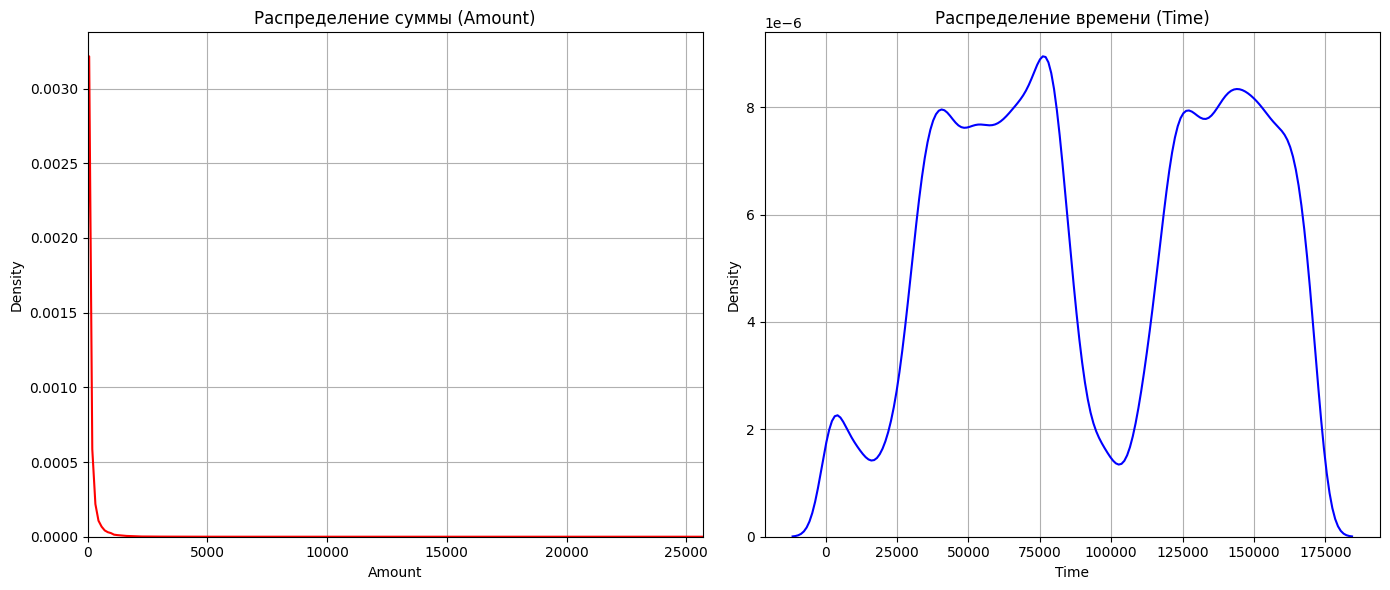

In [21]:

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=data['Amount'], color='r', ax=ax[0])
ax[0].set_title('Распределение суммы (Amount)')
ax[0].set_xlim([data['Amount'].min(), data['Amount'].max()])
ax[0].grid(True)

sns.kdeplot(data=data['Time'], color='b', ax=ax[1])
ax[1].set_title('Распределение времени (Time)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

Заметим что сумма транзакций `Amount` довольно сильно расходится. Возможно чтобы какие-то клиенты не перетягивали модель на себя, следует прологорифрировать эту фичу. **Посмотрим если зависимость мошеннических действий от суммы и времени**.

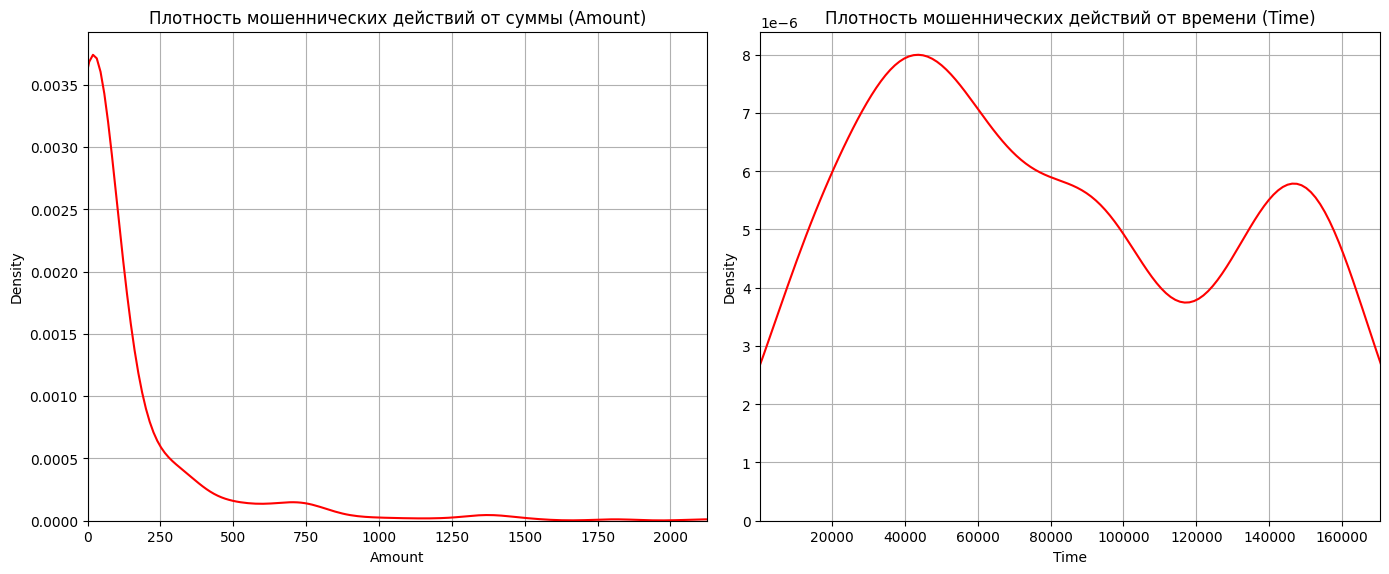

In [47]:
freud_data = data.loc[data['Class'] == 1, ['Time', 'Amount', 'Class']]
freud_mean = freud_data['Time'].mean()
freud_min = freud_data['Time'].min()
freud_max = freud_data['Time'].max()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=freud_data['Amount'], color='r', ax=ax[0])
ax[0].set_xlim([freud_data['Amount'].min(), freud_data['Amount'].max()])
ax[0].set_title('Плотность мошеннических действий от суммы (Amount)')
ax[0].grid(True)

sns.kdeplot(data=freud_data['Time'], color='r', ax=ax[1])
ax[1].set_xlim([freud_min, freud_max])
ax[1].set_title('Плотность мошеннических действий от времени (Time)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

**Большинство мошеннических операций происходят на суммах до 1000**. **Зависимость от времени не наблюдается**. Посмотрим отличие среднего и стандартного отклонения обычных операций от мошеннических.

In [24]:
mean_ordinary = round(data['Amount'].mean(), 2)
mean_fraud = round(freud_data['Amount'].mean(),2)

print(f'Средняя сумма транзаций по обычным действиям: {mean_ordinary}')
print(f'Средняя сумма транзаций по мошенническим действиям: {mean_fraud}')

Средняя сумма транзаций по обычным действиям: 88.47
Средняя сумма транзаций по мошенническим действиям: 123.87


**Средняя сумма** не сильно отличается, посмотрим разброс.

In [25]:
std_ordinary = round(data['Amount'].std(), 2)
std_fraud = round(freud_data['Amount'].std(),2)


print(f'Среднее отклонение суммы по обычным действиям: {std_ordinary}')
print(f'Среднее отклонение суммы по мошенническим действиям: {std_fraud}')

Среднее отклонение суммы по обычным действиям: 250.4
Среднее отклонение суммы по мошенническим действиям: 260.21


Судя по этим данными **мошеннические действия нельзя явно выделить**, т.к. они сливаются с обычными действиями.

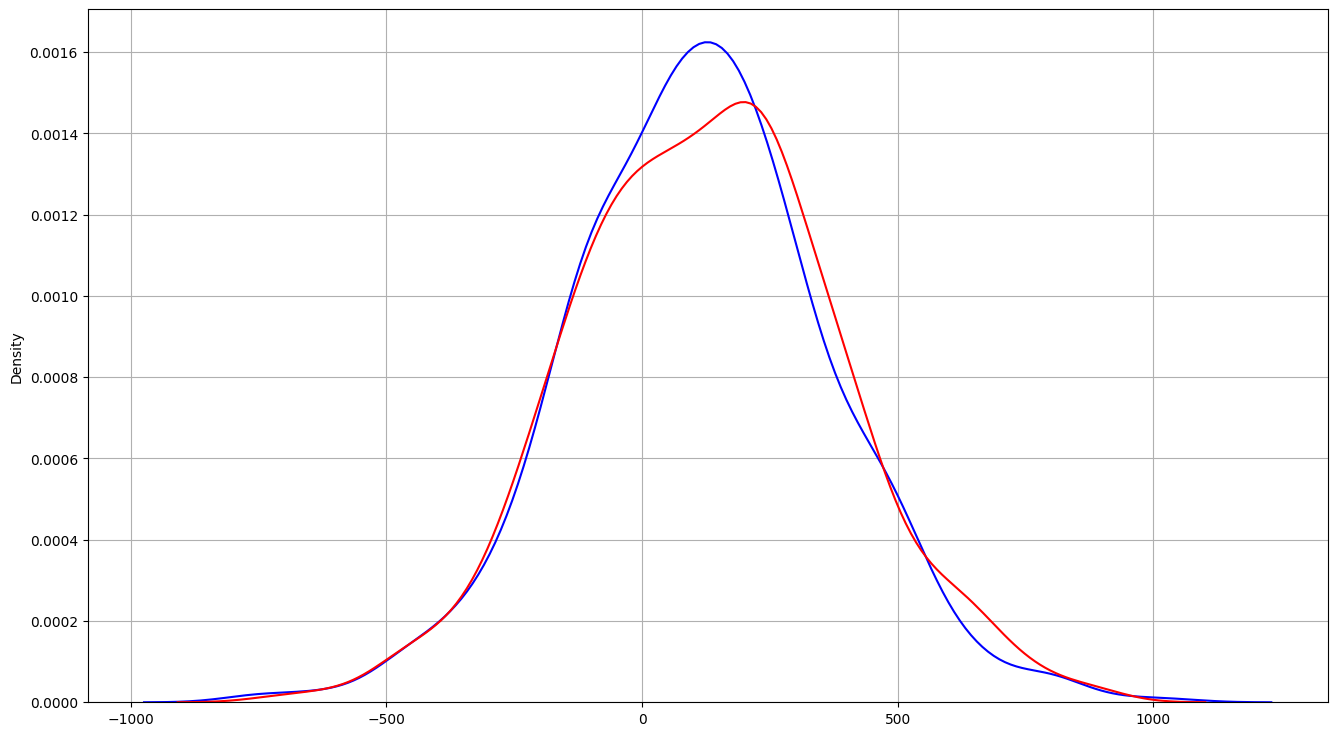

In [26]:
plt.figure(figsize=(16, 9))

sns.kdeplot(norm(mean_ordinary, std_ordinary).rvs(1000), color='b')
sns.kdeplot(norm(mean_fraud, std_fraud).rvs(1000), color='r')

plt.grid(True)
plt.show()

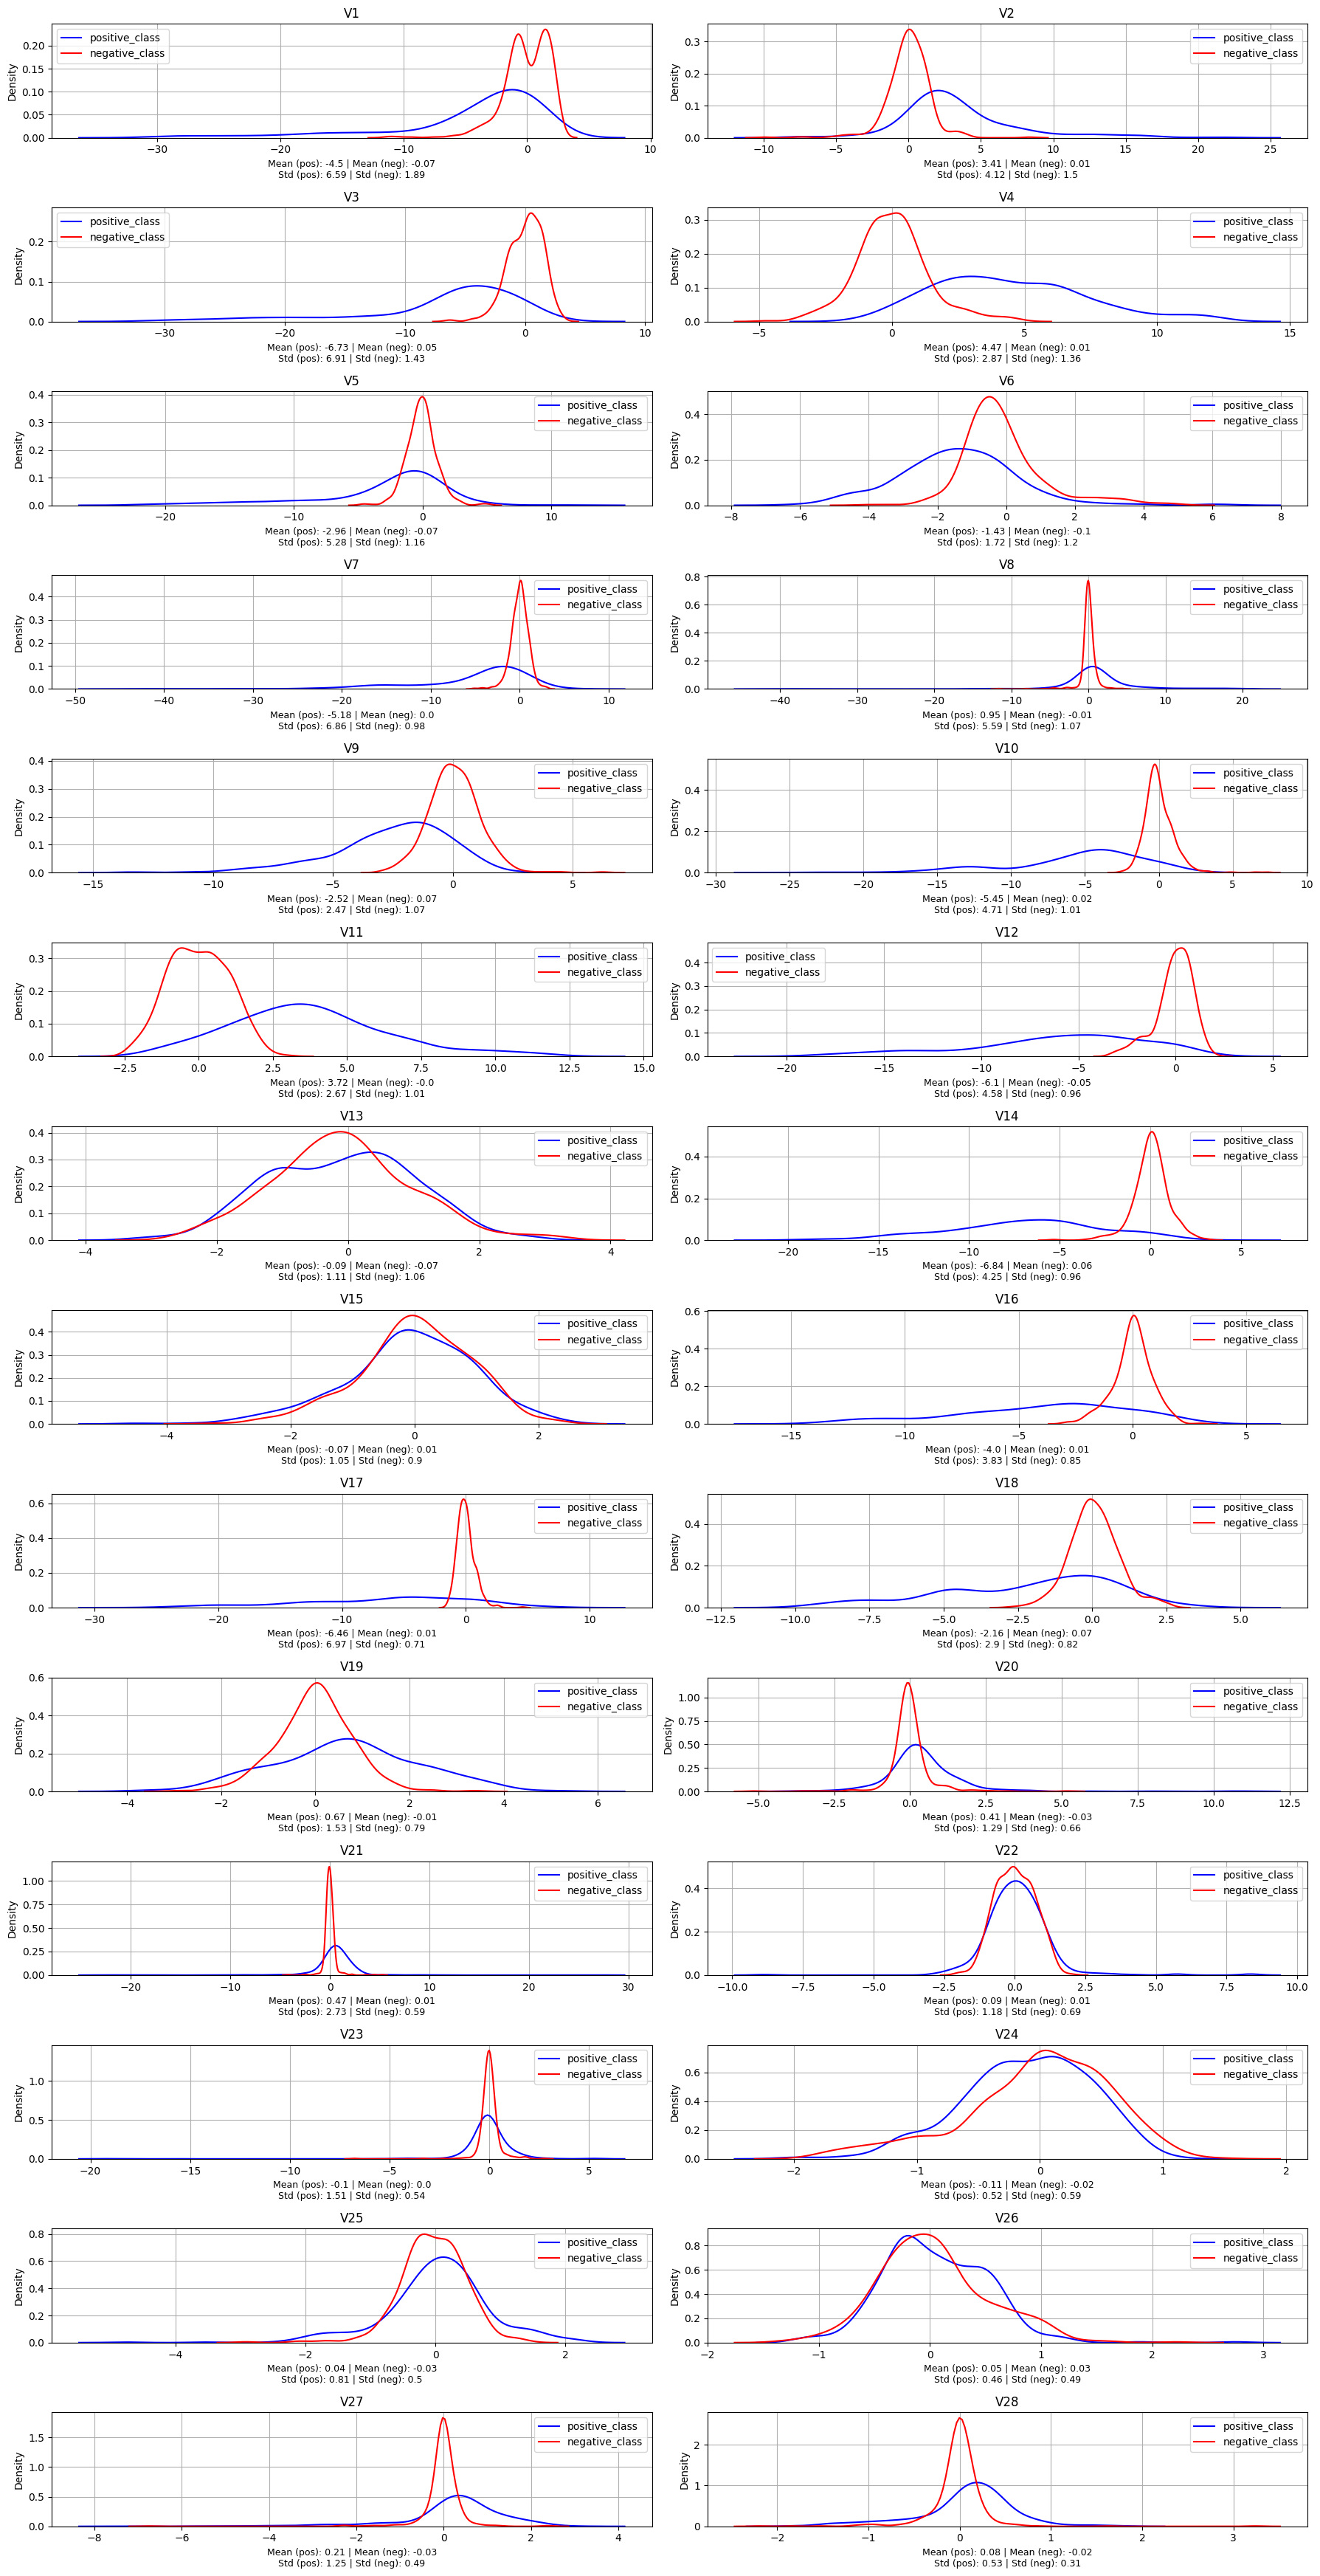

In [98]:
data_detected_fraud = data.copy().sample(frac=1, random_state=42)

negative_class = data_detected_fraud.loc[data_detected_fraud['Class'] == 0]
positive_class = data_detected_fraud.loc[data_detected_fraud['Class'] == 1]

negative_class = negative_class.sample(frac=1, random_state=42)[:len(positive_class)]

features = [col for col in data.columns if col not in ['Class', 'Time', 'Amount']]

fig, ax = plt.subplots(14, 2, figsize=(18,35))

for i, columns in enumerate(features):
    row, col = divmod(i, 2)

    sns.kdeplot(positive_class[columns], ax=ax[row][col], color='b')
    sns.kdeplot(negative_class[columns], ax=ax[row][col], color='r')

    pos_mean = round(positive_class[columns].mean(), 2)
    neg_mean = round(negative_class[columns].mean(), 2)

    pos_std = round(positive_class[columns].std(), 2)
    neg_std = round(negative_class[columns].std(), 2)


    ax[row][col].set_xlabel(
        f'Mean (pos): {pos_mean} | Mean (neg): {neg_mean}\n'
        f'Std (pos): {pos_std} | Std (neg): {neg_std}', fontsize=9)

    ax[row][col].set_title(columns)
    ax[row][col].grid(True)
    ax[row][col].legend(['positive_class', 'negative_class'])

plt.tight_layout()
plt.show()

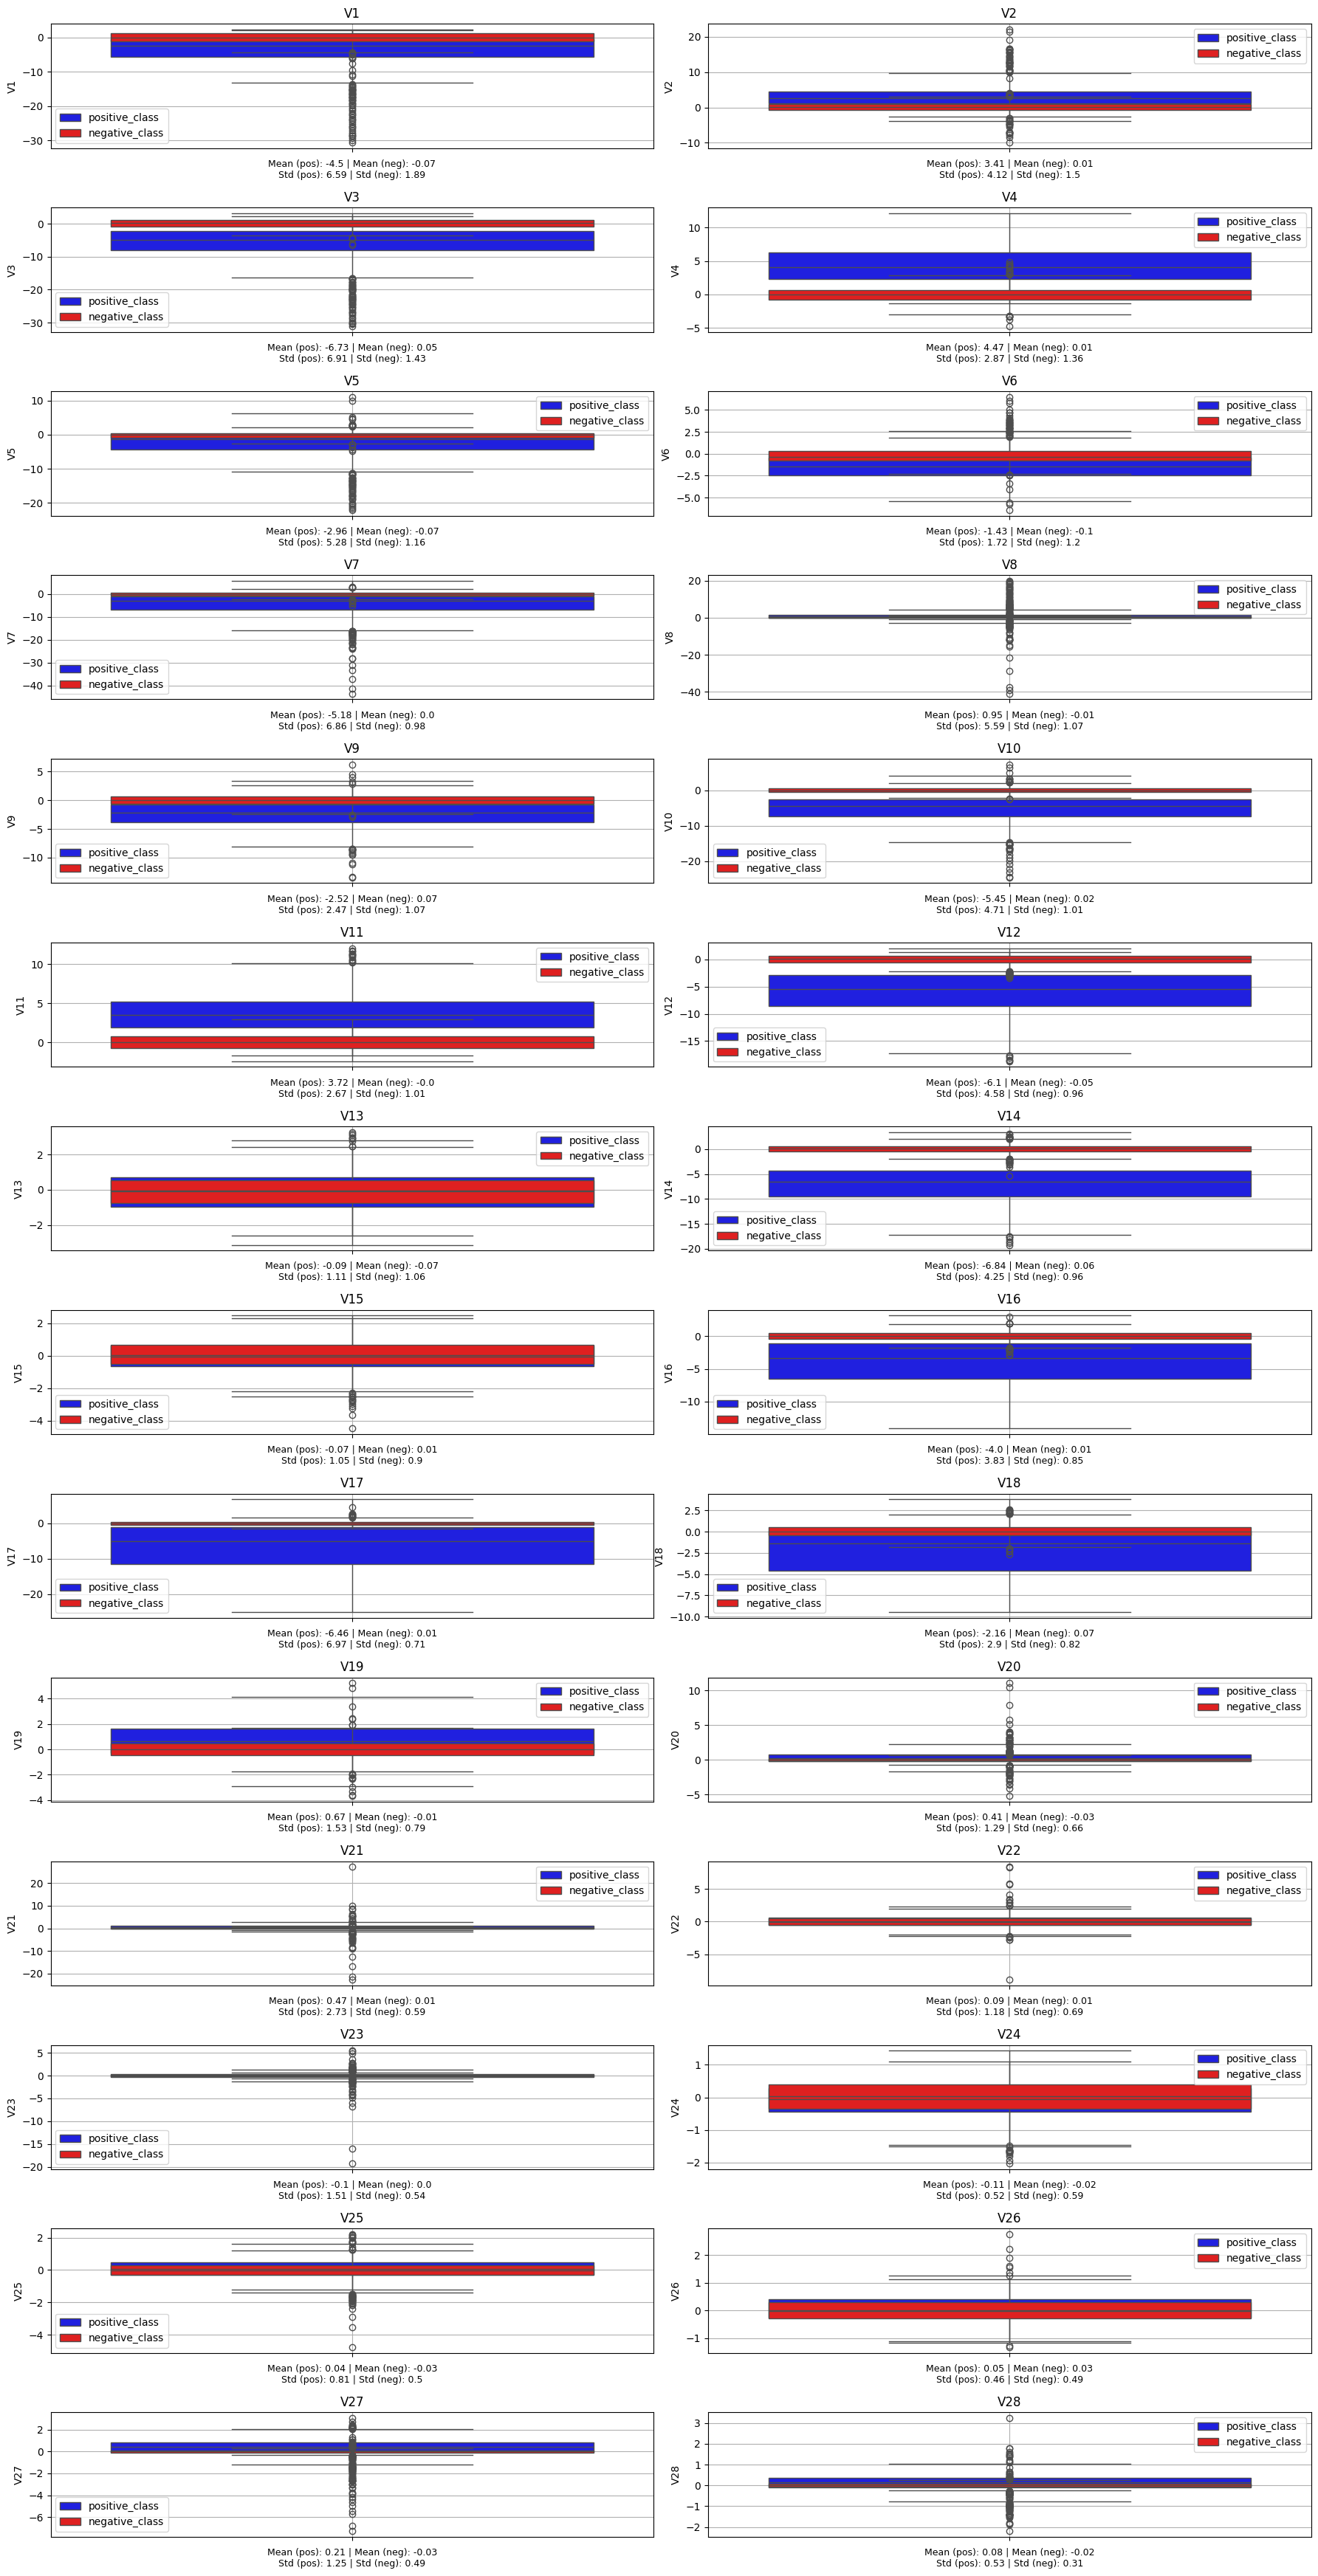

In [99]:
fig, ax = plt.subplots(14, 2, figsize=(18,35))

for i, columns in enumerate(features):
    row, col = divmod(i, 2)

    sns.boxplot(positive_class[columns], ax=ax[row][col], color='b')
    sns.boxplot(negative_class[columns], ax=ax[row][col], color='r')

    pos_mean = round(positive_class[columns].mean(), 2)
    neg_mean = round(negative_class[columns].mean(), 2)

    pos_std = round(positive_class[columns].std(), 2)
    neg_std = round(negative_class[columns].std(), 2)


    ax[row][col].set_xlabel(
        f'Mean (pos): {pos_mean} | Mean (neg): {neg_mean}\n'
        f'Std (pos): {pos_std} | Std (neg): {neg_std}', fontsize=9)

    ax[row][col].set_title(columns)
    ax[row][col].grid(True)
    ax[row][col].legend(['positive_class', 'negative_class'])

plt.tight_layout()
plt.show()

### 3. Baseline

Произведем разделение данных на фичи и целевую переменную.

In [28]:
X, y = data.drop(columns=['Class']), data['Class']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

Из столбцов для количественных фичей удалим целевую метрику.

In [29]:
numeric_columns_eda = [col for col in numeric_columns_eda if col != 'SalePrice']

Подготовим базовую модель предсказывающую наугад.

In [ ]:
1baseline_model = DummyClassifier()

In [31]:
#baseline = data_tools.PipelineManager(data, baseline_model).get_baseline()

In [32]:
baseline_model = DummyClassifier()
baseline_model.fit(X_train, y_train)

predict_dummy = baseline_model.predict(X_val)
baseline_recall = round(recall_score(y_val, predict_dummy), 2)
baseline_presicion = round(precision_score(y_val, predict_dummy), 2)
baseline_f1 = round(f1_score(y_val, predict_dummy), 2)

print(f'Recall baseline: {baseline_recall}')
print(f'Precision baseline: {baseline_presicion}')
print(f'F1 baseline: {baseline_f1}')

Recall baseline: 0.0
Precision baseline: 0.0
F1 baseline: 0.0


c:\Users\46120\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)

predict_dummy = baseline_model.predict(X_val)
baseline_recall = round(recall_score(y_val, predict_dummy), 2)
baseline_presicion = round(precision_score(y_val, predict_dummy), 2)
baseline_f1 = round(f1_score(y_val, predict_dummy), 2)

print(f'Recall baseline: {baseline_recall}')
print(f'Precision baseline: {baseline_presicion}')
print(f'F1 baseline: {baseline_f1}')

KeyboardInterrupt: 

Вывод